# Vorbereitungen

In [31]:
#LOCAL dient als Unterscheidung, ob das Notebook lokal oder in Google-Colab ausgeführt wird.
#LOCAL == True bedeutet das Jupyter Notebook wird lokal ausgeführt.
#LOCAL == False bedeutet das Notebook wird in Google-Colab ausgeführt.
LOCAL = False


if LOCAL==False:
  # Einbinden des eigenen Google-Drive
  # - CLM auf den erscheinenden Link
  # - Google-Koto auswaehlen
  # - Die Verwendung zulassen (ggf. ganz nach unten scrollen)
  from google.colab import drive
  drive.mount('/content/drive')

  # Definition des Basis-Verzeichnisses
  # Dieses wird hier so festgelegt, dass man im Google-Drive unter
  #     /Colab_Drive/ML_TH/
  # arbeitet. Das BASEDIR MUSS BEREITS EXISTIEREN, also von Hand angelegt worden sein.
  BASEDIR='/content/drive/My Drive/Colab_Drive/ESP/'
else:
  BASEDIR='/tf/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Weitere vorausgesetzte Verzeichnisse anlegen
import os

DATADIR = 'data_input'
if os.path.exists(BASEDIR + DATADIR):
  print("Das Verzeichnis  "+BASEDIR+DATADIR+"   existiert bereits")
else:
  os.mkdir(BASEDIR + DATADIR)

TMPDIR = 'tmp'
if os.path.exists(BASEDIR + TMPDIR):
  print("Das Verzeichnis  "+BASEDIR+TMPDIR+"   existiert bereits")
else:
  os.mkdir(BASEDIR + TMPDIR)

Das Verzeichnis  /content/drive/My Drive/Colab_Drive/ESP/data_input   existiert bereits
Das Verzeichnis  /content/drive/My Drive/Colab_Drive/ESP/tmp   existiert bereits


In [33]:
# libs importieren
#!pip install keras==2.10.0
#!pip install tensorflow==2.10.0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa.util
import joblib

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import Input

from tensorflow.keras import initializers
from tensorflow.keras import utils               # Hiervon wird to_categorical() benötigt

# Fuer das Handling von Bildern
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import img_to_array

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from IPython.display import Audio

In [34]:
TEST_FILE_PATH = BASEDIR + DATADIR + "/" + "test2.wav"
Audio(TEST_FILE_PATH)

Output hidden; open in https://colab.research.google.com to view.

# Preprocessing der Daten


Setzen einiger Konstanten/Parameter:

In [35]:

TARGET_SAMPLE_RATE = 16000  # Ziel Sample-Rate = 16 kHz
SAMPLE_LENGTH_SECONDS = 5   # von jedem Audio-Sample werden die ersten xx Sekunden betrachtet
FRAME_LENGTH = 1024         # Frame-Länge in Samples
HOP_LENGTH = 512            # Überlappung der Frames (1024-512 = 512 Überlappung)
N_MELS = 30
N_SPECTROGRAMS = 10
N_SAMPLES_PER_AUDIOSUBSAMPLE = HOP_LENGTH * 31 + FRAME_LENGTH

class_names = ['bass', 'pitched', 'sustained', 'rhythmic', 'melodic']

In [36]:
#   This software component is licensed by ST under BSD 3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#                        https://opensource.org/licenses/BSD-3-Clause

"""LogMel Feature Extraction example."""

import numpy as np
import sys
import librosa
import librosa.display
import scipy.fftpack as fft

SR = TARGET_SAMPLE_RATE
N_FFT = FRAME_LENGTH

def create_col(y):
    assert y.shape == (1024,)

    # Create time-series window
    fft_window = librosa.filters.get_window('hann', N_FFT, fftbins=True)
    assert fft_window.shape == (1024,), fft_window.shape

    # Hann window
    y_windowed = fft_window * y
    assert y_windowed.shape == (1024,), y_windowed.shape

    # FFT
    fft_out = fft.fft(y_windowed, axis=0)[:513]
    assert fft_out.shape == (513,), fft_out.shape

    # Power spectrum
    S_pwr = np.abs(fft_out)**2

    assert S_pwr.shape == (513,)

    # Generation of Mel Filter Banks
    mel_basis = librosa.filters.mel(sr=SR, n_fft=N_FFT, n_mels=N_MELS, htk=False)
    assert mel_basis.shape == (N_MELS, 513)

    # Apply Mel Filter Banks
    S_mel = np.dot(mel_basis, S_pwr)
    S_mel.astype(np.float32)
    assert S_mel.shape == (30,)

    return S_mel


def feature_extraction(y):
    assert y.shape == (32, 1024)

    S_mel = np.empty((30, 32), dtype=np.float32, order='C')
    for col_index in range(0, 32):
        S_mel[:, col_index] = create_col(y[col_index])

    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=80.0)
    assert S_log_mel.shape == (30, 32)

    return S_log_mel

# Betrachten der Klassifizierung einer einzelnen Datei

In [37]:
from tensorflow.keras.models import load_model

# Modell laden
model = load_model(os.path.join(BASEDIR + 'model.h5'))
# scaler laden
scaler = joblib.load(os.path.join(BASEDIR + 'scaler.pkl'))

In [38]:
### Datei einlesen ###
test_file = os.path.join(TEST_FILE_PATH)
samples, sample_rate = librosa.load(test_file, sr=TARGET_SAMPLE_RATE, mono=True)
data_np = np.array(samples, dtype=object)

### Datei aufsplitten ###
audiosubsamples = []
audiosubsample_labels = []

# Iteriere über alle Audiodateien
file_length = len(data_np)
n_audiosubsamples_in_file = file_length // N_SAMPLES_PER_AUDIOSUBSAMPLE

# Generiere Subsamples
for j in range(n_audiosubsamples_in_file):
    start_index = j * N_SAMPLES_PER_AUDIOSUBSAMPLE
    end_index = start_index + N_SAMPLES_PER_AUDIOSUBSAMPLE
    audiosubsamples.append(data_np[start_index:end_index])

# Wenn die Datei kürzer ist als N_SAMPLES_PER_AUDIOSUBSAMPLE, padde sie auf die Standardlänge
if file_length < N_SAMPLES_PER_AUDIOSUBSAMPLE:
    padded_sample = np.pad(data_np, (0, N_SAMPLES_PER_AUDIOSUBSAMPLE - file_length), mode='constant', constant_values=0)
    audiosubsamples.append(padded_sample)

# Konvertierung der Listen zurück in NumPy-Arrays
audiosubsamples_np = np.array(audiosubsamples, dtype=object)


In [39]:
def create_frames(data):
    framed_data = []
    for sample in data:
        file_length = len(sample)
        n_audiosubsamples_in_file = file_length // N_SAMPLES_PER_AUDIOSUBSAMPLE

        if n_audiosubsamples_in_file < 1:
            # Pad sample, wenn es kleiner als ein Subsample ist
            sample = np.pad(sample, (0, N_SAMPLES_PER_AUDIOSUBSAMPLE - file_length), 'constant')
        else:
            # Berechne die benötigte Sample-Länge für korrekte Framing
            n_samples = (n_audiosubsamples_in_file * N_SAMPLES_PER_AUDIOSUBSAMPLE)
            sample = sample[:n_samples]

        # Frames erstellen
        frames = librosa.util.frame(sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        framed_data.append(np.transpose(frames))
    return framed_data


x_framed = create_frames(audiosubsamples_np)

In [40]:
def convert_to_1d(spectrogram):
    """
    Konvertiert ein 2D-Spektrogramm in ein 1D-Array,
    in der gleichen Reihenfolge wie im C-Code.

    Args:
    - spectrogram (np.array): 2D-Array (S_log_mel) mit Form (30, 32)

    Returns:
    - np.array: 1D-Array mit 960 Elementen
    """
    assert spectrogram.shape == (30, 32), "Spektrogramm muss die Form (30, 32) haben"

    # Erstelle ein 1D-Array und kopiere die Werte in der gewünschten Reihenfolge
    spectrogram_1d = np.empty(30 * 32, dtype=np.float32)

    for i in range(30):
        for j in range(32):
            spectrogram_1d[i * 32 + j] = spectrogram[i, j]

    return spectrogram_1d

In [41]:
import matplotlib.pyplot as plt

def plot_logmel_spectrogram(feature, sr, title):
    plt.figure(figsize=(10, 4))
    # librosa.display.specshow(feature, sr=sr, y_axis='mel', fmax=16000, x_axis='time', cmap='viridis', vmin=-80.0)
    librosa.display.specshow(feature,
                             sr=sr,
                             vmin=-80.0,
                             y_axis='mel', fmax=64000, x_axis='time',
                             cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

100%|██████████| 17/17 [00:01<00:00,  9.31it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


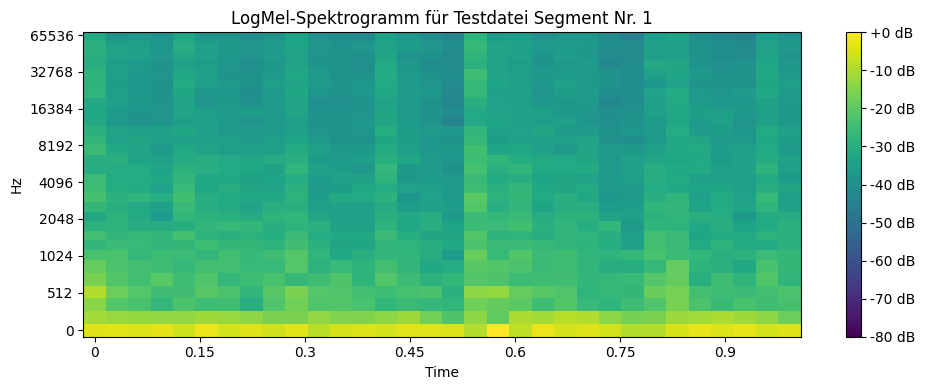

Segment 1:
  bass: Ähnlichkeit 0.12
  pitched: Ähnlichkeit 0.28
  sustained: Ähnlichkeit 0.06
  rhythmic: Ähnlichkeit 0.93
  melodic: Ähnlichkeit 0.37

Spectrogram data first segment
Index: 0, Wert: -4.322847843170166
Index: 1, Wert: -3.6238768100738525
Index: 2, Wert: -4.381268501281738
Index: 3, Wert: -3.2586491107940674
Index: 4, Wert: -6.222916126251221
Index: 5, Wert: -2.4936282634735107
Index: 6, Wert: -5.48513650894165
Index: 7, Wert: -4.254377365112305
Index: 8, Wert: -5.778216361999512
Index: 9, Wert: -3.592597246170044
Index: 10, Wert: -8.484495162963867
Index: 11, Wert: -5.182629585266113
Index: 12, Wert: -4.443138122558594
Index: 13, Wert: -5.428281307220459
Index: 14, Wert: -3.9743125438690186
Index: 15, Wert: -3.9409983158111572
Index: 16, Wert: -4.649489402770996
Index: 17, Wert: -9.562826156616211
Index: 18, Wert: 0.0
Index: 19, Wert: -7.949724197387695
Index: 20, Wert: -2.2601938247680664
Index: 21, Wert: -5.3012895584106445
Index: 22, Wert: -4.13638973236084
Index: 23

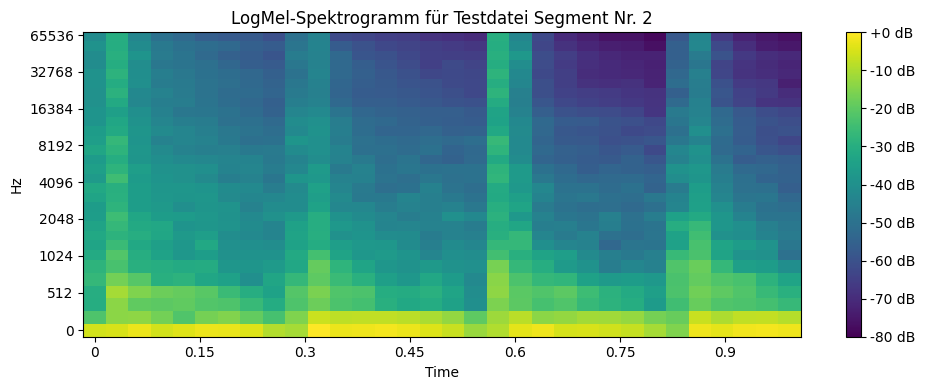

Segment 2:
  bass: Ähnlichkeit 0.21
  pitched: Ähnlichkeit 0.07
  sustained: Ähnlichkeit 0.00
  rhythmic: Ähnlichkeit 0.79
  melodic: Ähnlichkeit 0.53




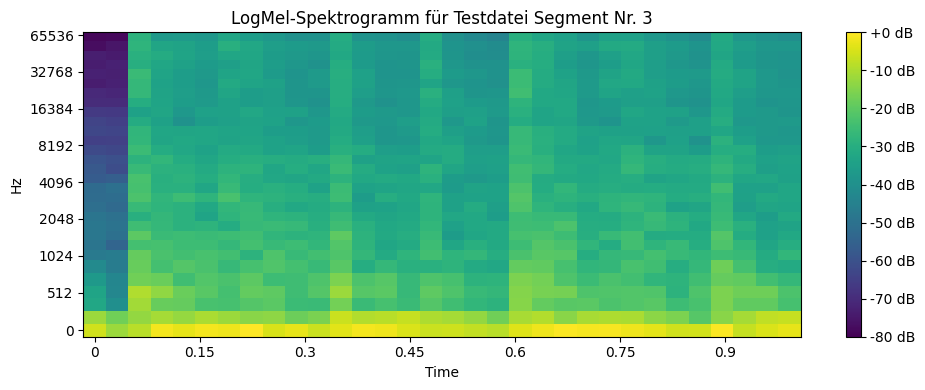

Segment 3:
  bass: Ähnlichkeit 0.06
  pitched: Ähnlichkeit 0.09
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.94
  melodic: Ähnlichkeit 0.36




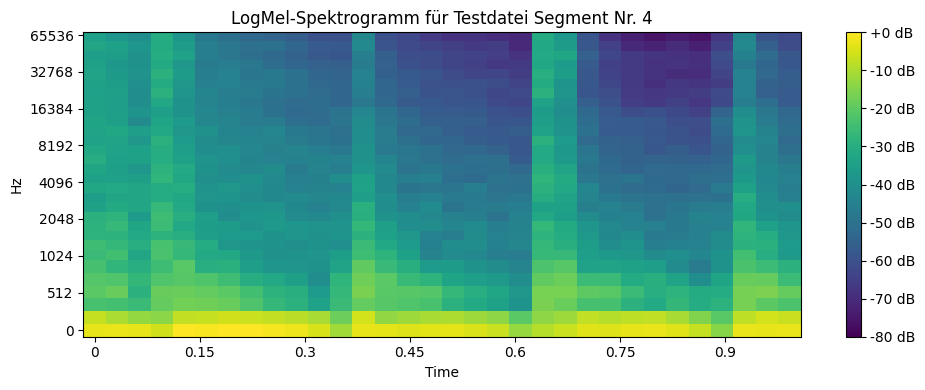

Segment 4:
  bass: Ähnlichkeit 0.17
  pitched: Ähnlichkeit 0.09
  sustained: Ähnlichkeit 0.00
  rhythmic: Ähnlichkeit 0.91
  melodic: Ähnlichkeit 0.50




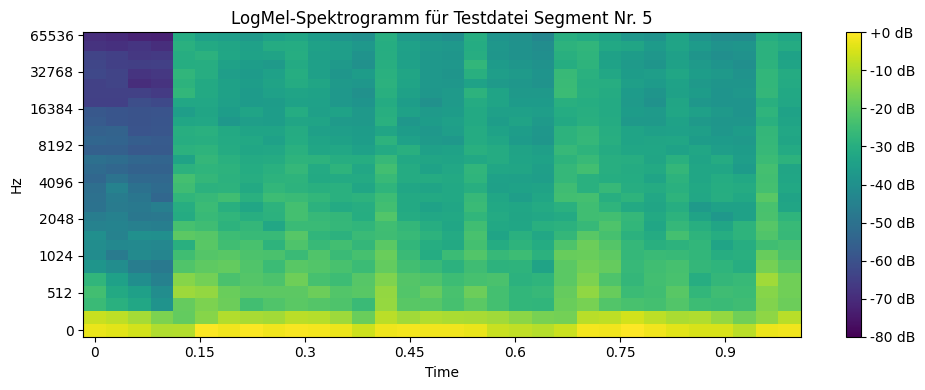

Segment 5:
  bass: Ähnlichkeit 0.06
  pitched: Ähnlichkeit 0.09
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.89
  melodic: Ähnlichkeit 0.41




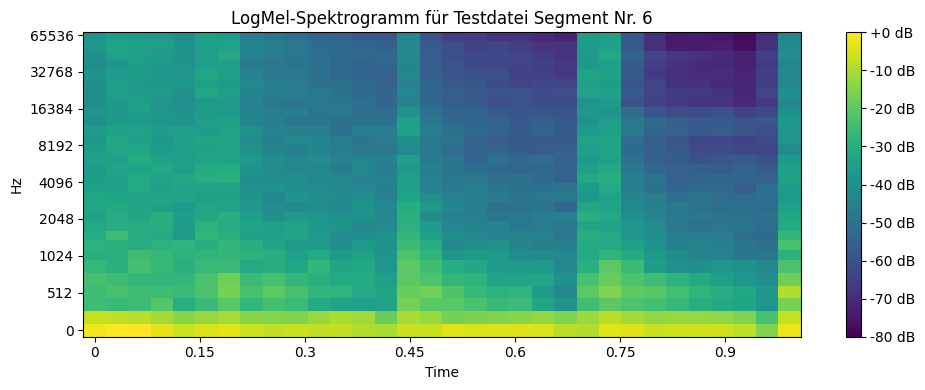

Segment 6:
  bass: Ähnlichkeit 0.28
  pitched: Ähnlichkeit 0.18
  sustained: Ähnlichkeit 0.01
  rhythmic: Ähnlichkeit 0.93
  melodic: Ähnlichkeit 0.42




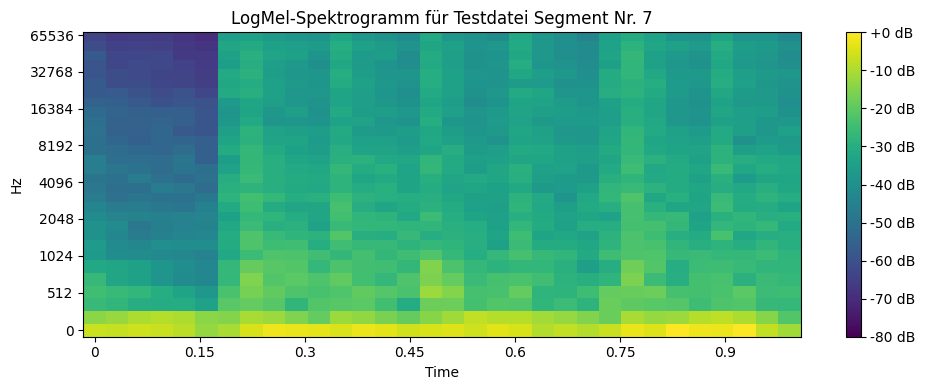

Segment 7:
  bass: Ähnlichkeit 0.08
  pitched: Ähnlichkeit 0.28
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.90
  melodic: Ähnlichkeit 0.46




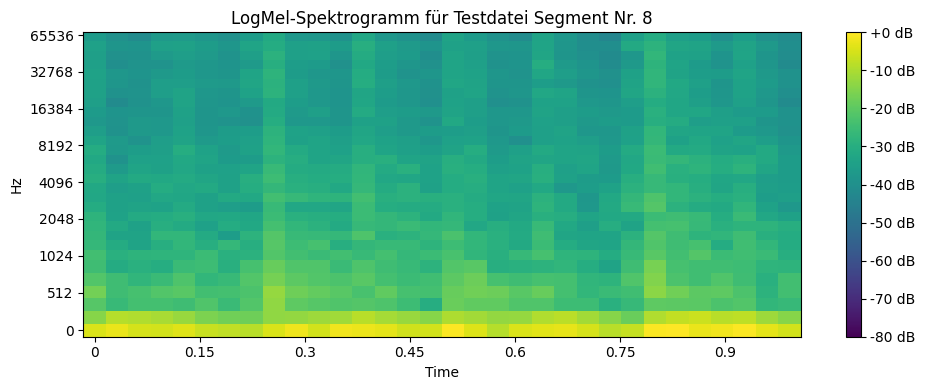

Segment 8:
  bass: Ähnlichkeit 0.14
  pitched: Ähnlichkeit 0.33
  sustained: Ähnlichkeit 0.07
  rhythmic: Ähnlichkeit 0.76
  melodic: Ähnlichkeit 0.43




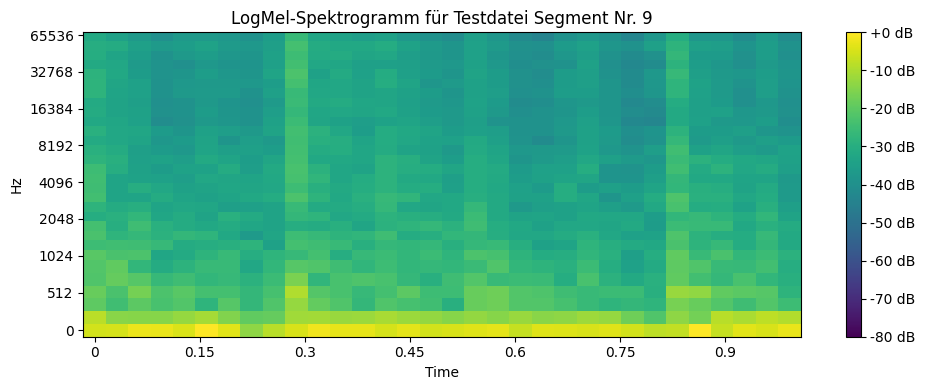

Segment 9:
  bass: Ähnlichkeit 0.13
  pitched: Ähnlichkeit 0.48
  sustained: Ähnlichkeit 0.05
  rhythmic: Ähnlichkeit 0.86
  melodic: Ähnlichkeit 0.30




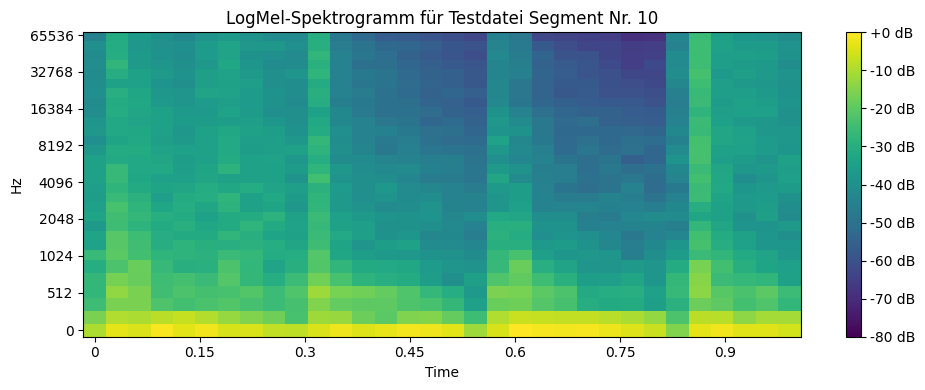

Segment 10:
  bass: Ähnlichkeit 0.27
  pitched: Ähnlichkeit 0.41
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.97
  melodic: Ähnlichkeit 0.45




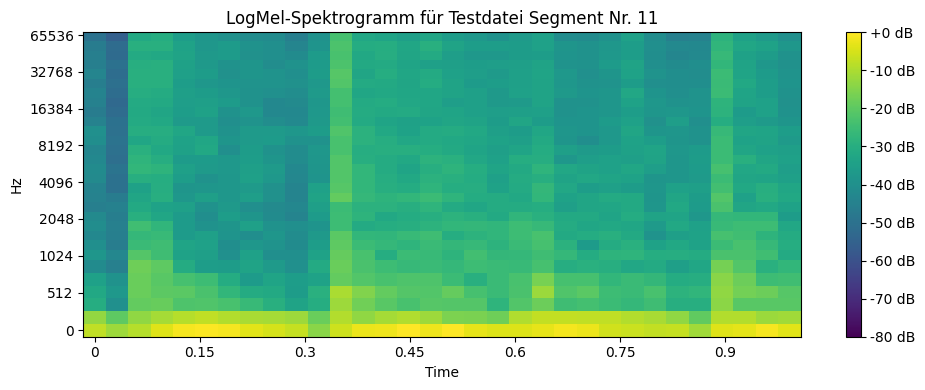

Segment 11:
  bass: Ähnlichkeit 0.09
  pitched: Ähnlichkeit 0.38
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.90
  melodic: Ähnlichkeit 0.20




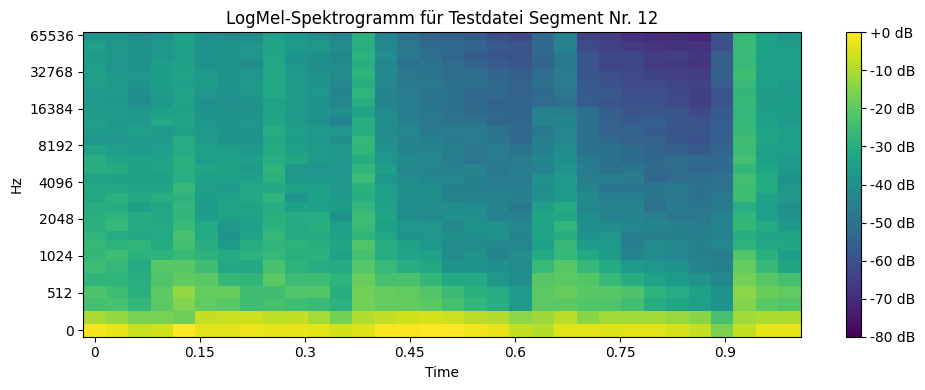

Segment 12:
  bass: Ähnlichkeit 0.21
  pitched: Ähnlichkeit 0.20
  sustained: Ähnlichkeit 0.01
  rhythmic: Ähnlichkeit 0.93
  melodic: Ähnlichkeit 0.24




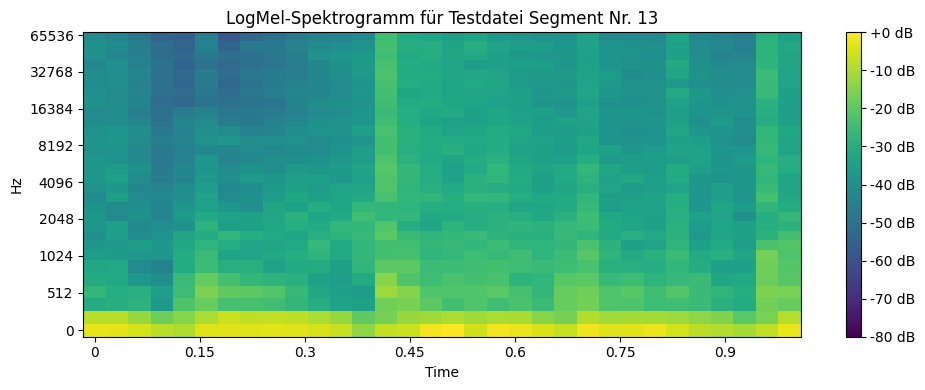

Segment 13:
  bass: Ähnlichkeit 0.13
  pitched: Ähnlichkeit 0.18
  sustained: Ähnlichkeit 0.04
  rhythmic: Ähnlichkeit 0.85
  melodic: Ähnlichkeit 0.26




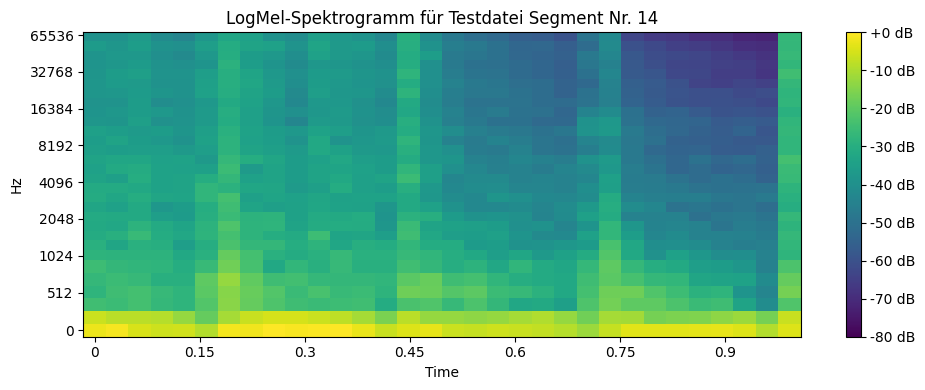

Segment 14:
  bass: Ähnlichkeit 0.21
  pitched: Ähnlichkeit 0.22
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.87
  melodic: Ähnlichkeit 0.49




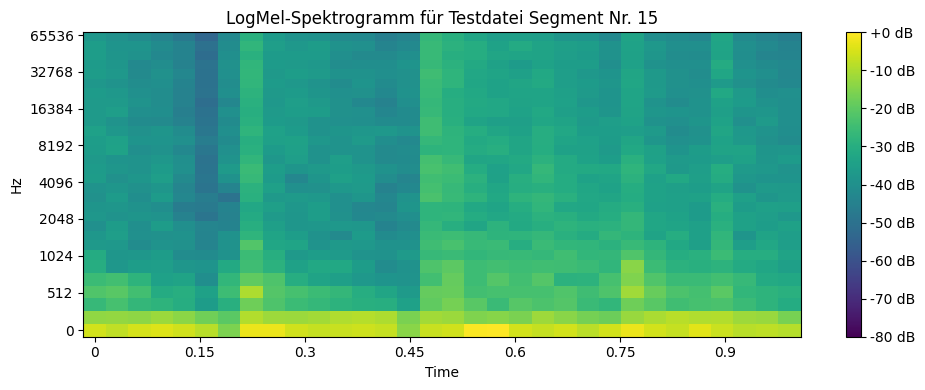

Segment 15:
  bass: Ähnlichkeit 0.10
  pitched: Ähnlichkeit 0.13
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.97
  melodic: Ähnlichkeit 0.21




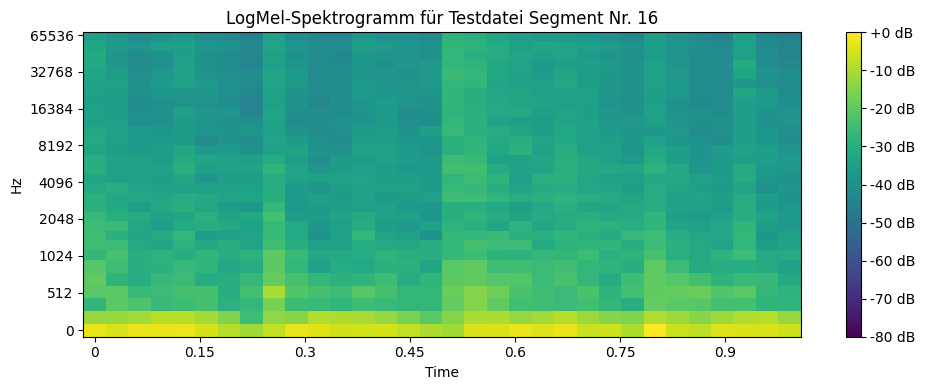

Segment 16:
  bass: Ähnlichkeit 0.09
  pitched: Ähnlichkeit 0.17
  sustained: Ähnlichkeit 0.04
  rhythmic: Ähnlichkeit 0.93
  melodic: Ähnlichkeit 0.33




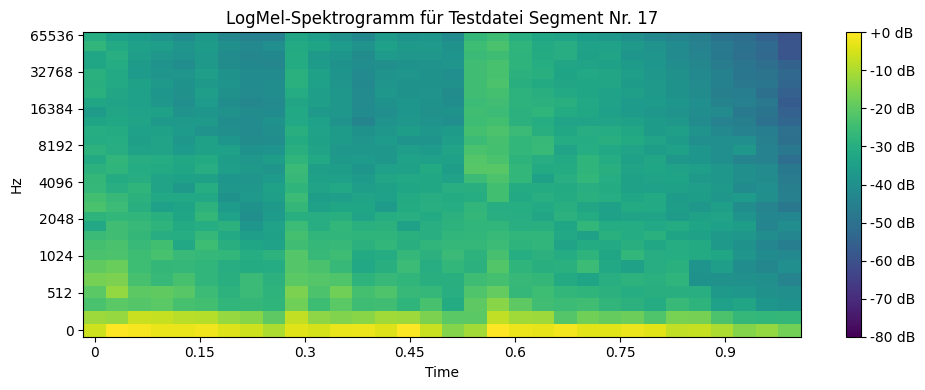

Segment 17:
  bass: Ähnlichkeit 0.14
  pitched: Ähnlichkeit 0.32
  sustained: Ähnlichkeit 0.02
  rhythmic: Ähnlichkeit 0.97
  melodic: Ähnlichkeit 0.15


Durchschnittliche Ähnlichkeiten:
bass: Ähnlichkeit 0.15
pitched: Ähnlichkeit 0.23
sustained: Ähnlichkeit 0.03
rhythmic: Ähnlichkeit 0.90
melodic: Ähnlichkeit 0.36


In [43]:
def preprocess_data(x_framed):
    """
      Umwandlung der Samples in LogMel Spectogram Features. Mehr Informationen:
      https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
      https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
      LogMel Sepctogram Features sind eine Art von Sepktogramm, Erklärung:
        1. Fourier-Transformation: Wandelt das Signal von Zeitabhängigkeit in Frequenzabhängigkeit um.
        2. Mel-Filterbank: Das Frequenzspektrum wird durch eine Reihe von Filtern verarbeitet, die
            auf der Mel-Skala basieren. Diese Skala approximiert die menschliche Hörwahrnehmung besser
            als die lineare Frequenzskalierung.
        3. Logarithmische Skalierung: Der Logarithmus der durch die Mel-Filterbank erhaltenen Energien
            wird genommen, um die Features an die logarithmische Wahrnehmung des menschlichen Gehörs
            anzupassen.
    """
    features = []

    # i: Schleife über alle Dateien
    for i in tqdm(range(len(x_framed))):
        n_features_per_file = x_framed[i].shape[0] // 32
        # j: Schleife über alle Spektrogramme, die aus jeder Datei extrahiert werden sollen
        for j in range(n_features_per_file):
            # Extrahieren eines Frames, der für die Feature-Extraktion verwendet wird
            start_index = j * 32
            end_index = start_index + 32
            frame = x_framed[i][start_index:end_index]

            # Feature-Extraktion durchführen
            feature = feature_extraction(frame)
            features.append(feature)

    # Umwandeln von Listen in numpy Arrays
    features = np.array(features, dtype='float32')
    return features

def predict_segments(features):
    features = features.reshape(features.shape[0], 30, 32, 1)
    return model.predict(features)

def aggregate_predictions_and_print_corresponding_spectrograms(features, predictions, class_names):
    count = 0
    # Ausgabe jeder einzelnen Vorhersage
    for index, pred in enumerate(predictions):
        # Ausgabe des Spektrogramms
        feature = features[index]
        title = f"LogMel-Spektrogramm für Testdatei Segment Nr. {index+1}"
        plot_logmel_spectrogram(feature, sr=16000, title=title)
        # Ausgabe der Vorhersagen
        print(f"Segment {index+1}:")
        for i, class_name in enumerate(class_names):
            print(f"  {class_name}: Ähnlichkeit {pred[i]:.2f}")
        print("")
        one_dim_spectrogram = convert_to_1d(feature)
        # print spectrogram values by index
        if (count == 0):
          print("Spectrogram data first segment")
          for index, value in enumerate(one_dim_spectrogram):
            print(f"Index: {index}, Wert: {value}")
        count = count + 1
        print("")

    # Berechnung und Rückgabe der durchschnittlichen Ähnlichkeiten
    mean_predictions = np.mean(predictions, axis=0)
    return mean_predictions

def display_results(aggregated_predictions, class_names):
    for class_name, value in zip(class_names, aggregated_predictions):
        print(f"{class_name}: Ähnlichkeit {value:.2f}")

final_eval_features = preprocess_data(x_framed)

# features für scaling flattenen
final_eval_features_r = final_eval_features.reshape(len(final_eval_features), 30 * 32)

# den scaler anwenden
final_eval_features_s = scaler.transform(final_eval_features_r)

predictions = predict_segments(final_eval_features_s)
aggregated_predictions = aggregate_predictions_and_print_corresponding_spectrograms(final_eval_features, predictions, class_names)

print("Durchschnittliche Ähnlichkeiten:")
display_results(aggregated_predictions, class_names)
